<a href="https://colab.research.google.com/github/eviatarbach/variational_filtering/blob/main/SEnKF_Lorenz_96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def lorenz96(x, dt, F=8.0):
    dxdt = np.zeros_like(x)
    N = len(x)
    for i in range(N):
        dxdt[i] = (x[(i+1) % N] - x[(i-2) % N]) * x[(i-1)%N] - x[i%N] + F
    return x + dt * dxdt
# Runge Kutta Integration
# def lorenz96(x, dt, F=8.0):
#     N = len(x)
#     k1 = np.zeros_like(x)
#     k2 = np.zeros_like(x)
#     k3 = np.zeros_like(x)
#     k4 = np.zeros_like(x)
#     for i in range(N):
#         k1[i] = dt * ((x[(i+1) % N] - x[(i-2) % N]) * x[(i-1) % N] - x[i] + F)
#     for i in range(N):
#         k2[i] = dt * ((x[(i+1) % N] - x[(i-2) % N]) * (x[(i-1) % N] + k1[(i-1) % N]/2) - (x[i] + k1[i]/2) + F)
#     for i in range(N):
#         k3[i] = dt * ((x[(i+1) % N] - x[(i-2) % N]) * (x[(i-1) % N] + k2[(i-1) % N]/2) - (x[i] + k2[i]/2) + F)
#     for i in range(N):
#         k4[i] = dt * ((x[(i+1) % N] - x[(i-2) % N]) * (x[(i-1) % N] + k3[(i-1) % N]) - (x[i] + k3[i]) + F)
#     x_new = x + (k1 + 2*k2 + 2*k3 + k4)/6
#     return x_new


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def visualize_lorenz96_observations(observations):
    # Extract timestamps and observation values
    timestamps = list(observations.keys())
    obs = list(observations.values())
    observation_values = np.array(obs).T
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('CustomColormap', [(0, 'blue'), (0.5, 'white'), (1, 'red')])
    # Create a grid plot
    plt.figure(figsize=(12, 6))
    plt.imshow(observation_values, cmap=cmap, aspect='auto', vmin=-6, vmax=6)
    plt.colorbar(label='Observation Value')
    plt.xlabel('Time')
    plt.ylabel('State Number')
    plt.title('Lorenz 96 Observations Over Time')
    plt.show()


In [ ]:
def generate_observations(model, initial_state, n_timesteps, dt, observation_interval, R, Q, H):
    state = initial_state
    true_observations = {}
    true_states = {}
    for t in range(n_timesteps):
        true_states[t] = state
        state = model(state, dt)
        if t % observation_interval == 0:
            state = state + np.random.multivariate_normal(np.zeros(state.shape[0]), Q)
            true_observations[t] = H@state + np.random.multivariate_normal(np.zeros(H.shape[0]), R)
    return true_observations, true_states

In [ ]:
def generate_gc_localization_matrix(N, localization_radius):
    """
    Generate the Gaspari-Cohn (GC) localization matrix for data assimilation in Lorenz 96 model.

    :param N: Number of grid points in the Lorenz 96 model.
    :param localization_radius: Localization radius controlling the range of influence.
    :return: GC localization matrix.
    """
    localization_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            # Calculate the modulo distance between grid points i and j
            min_modulo_distance = min(abs(i - j), N - abs(i - j))
            if min_modulo_distance <= localization_radius:
                localization_matrix[i, j] = np.exp(-((min_modulo_distance / localization_radius) ** 2))

    return localization_matrix


In [ ]:
# Lorenz 96 model parameters
N = 20  # Number of state variables in Lorenz 96
F = 8.0

initial_state = F*np.ones(N)  # Initial state (equilibrium)

H = np.eye(N)  # Assuming full observation for simplicity
Q = 0.02 * np.eye(N)  # Model noise covariance
R = 0.2 * np.eye(N) # Observation noise covariance

truth_init = np.random.multivariate_normal(initial_state, Q)
n_timesteps = 1500
dt = 0.01
# Observation settings for Lorenz 96
observation_interval = 50  # Adjust as needed
observations, states = generate_observations(lorenz96, truth_init, n_timesteps, dt, observation_interval, R, Q, H)

#visualize_lorenz96_observations(states)


In [ ]:
def stochastic_ensemble_kalman_filter(model, state_dim, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, localization_matrix):
    """
    Stochastic Ensemble Kalman Filter generalized for any model.

    :param model: Model function.
    :param state_dim: Dimension of state.
    :param n_ensemble: Number of ensemble members.
    :param n_timesteps: Number of time steps.
    :param dt: Time step size.
    :param H: Observation matrix.
    :param observations: Observations at each time step.
    :param Q: Model noise covariance matrix.
    :return: Dictionary containing states, predictions, and observations over time.
    """
    data_storage = {
        'states': np.zeros((n_timesteps, state_dim, n_ensemble)), # Store the ensemble members' states
        'forecasts': np.zeros((n_timesteps, state_dim, n_ensemble)),  # Store forecasts
        'K_norms': np.zeros((n_timesteps))
    }
    ensemble = ensemble_init

    for t in range(n_timesteps):
        # Forecast step
        data_storage['states'][t] = ensemble

        forecast = model(ensemble, dt)
        if t < n_timesteps - 1:  # Shift forecasts to align with the corresponding time step
            data_storage['forecasts'][t + 1] = forecast
        if t in observations:    # Analysis step if observation is available
            Y_obs = observations[t]
            # Generate and adjust perturbations for each ensemble member's observation
            perturbations = np.array([np.random.multivariate_normal(np.zeros(state_dim), R) for _ in range(n_ensemble)])
            perturbations -= np.mean(perturbations)
            Y_obs_ensemble = np.array([Y_obs + perturbation for perturbation in perturbations])
            R_u = np.cov(perturbations.T)
            # Compute the empirical Kalman gain
            Pf = np.cov(forecast) + Q
            #print(Pf)
            P = Pf * localization_matrix  # Element-wise multiplication for localization
            K_u = P @ H.T @ np.linalg.pinv(H @ P @ H.T + R_u) #using pinv prevents singularity issues
            data_storage['K_norms'][t] = np.linalg.norm(K_u, 'fro') # K smaller means less trust in observations
            # Update ensemble states
            ensemble = forecast + K_u @ (Y_obs_ensemble.T - H @ forecast)
        else:
            # If no observation, use the forecast as the new state
            ensemble = forecast

    return data_storage

In [ ]:
def free_run(model, state_dim, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, localization_matrix):
    data_storage = {
        'states': np.zeros((n_timesteps, state_dim, n_ensemble)), # Store the ensemble members' states
        'forecasts': np.zeros((n_timesteps, state_dim, n_ensemble))  # Store forecasts
    }
    ensemble = ensemble_init

    for t in range(n_timesteps):
        # Forecast step
        data_storage['states'][t] = ensemble

        forecast = model(ensemble, dt)
        if t < n_timesteps - 1:  # Shift forecasts to align with the corresponding time step
            data_storage['forecasts'][t + 1] = forecast

        ensemble = forecast

    return data_storage

In [ ]:
# Kalman Filter parameters for Lorenz 96
#H = np.eye(N)  # Assuming full observation for simplicity
#Q = 0.02 * np.eye(N)  # Model noise covariance
#R = 0.02 * np.eye(N) # Observation noise covariance
n_ensemble = 10
ensemble_init = np.random.multivariate_normal(initial_state, Q, n_ensemble).T
radius = 2
local_mat = np.ones(N)#generate_gc_localization_matrix(N, radius)
# Run the Kalman Filter for Lorenz 96
data_storage = stochastic_ensemble_kalman_filter(lorenz96, N, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, local_mat)
free_run_data = free_run(lorenz96, N, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, local_mat)
average_state = np.mean(data_storage['states'], axis=2)  # Calculate the mean along the ensemble dimension
average_forecast = np.mean(data_storage['forecasts'], axis = 2)

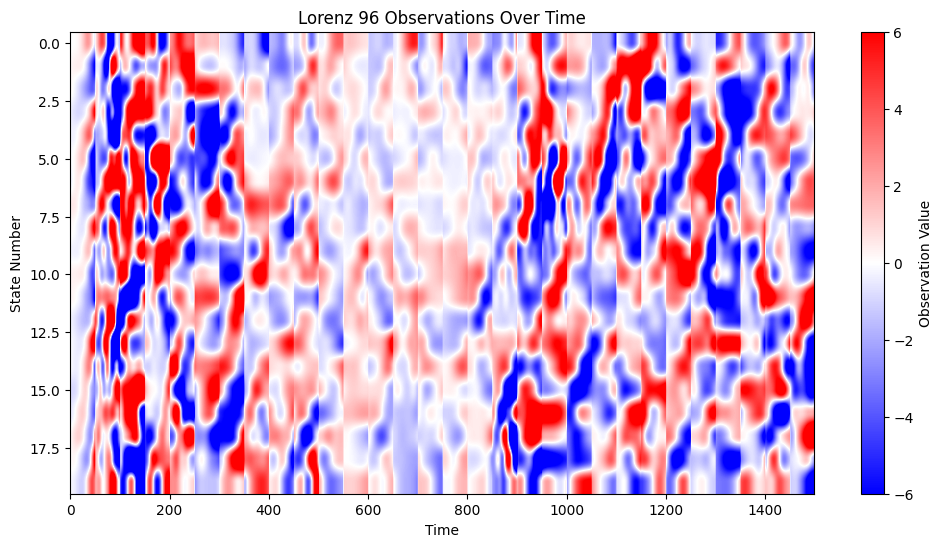

In [ ]:
forecast_errors = {}
t = 1
for forecast in average_forecast[1:]:
    forecast_errors[t] = forecast - states[t]
    t += 1

visualize_lorenz96_observations(forecast_errors)


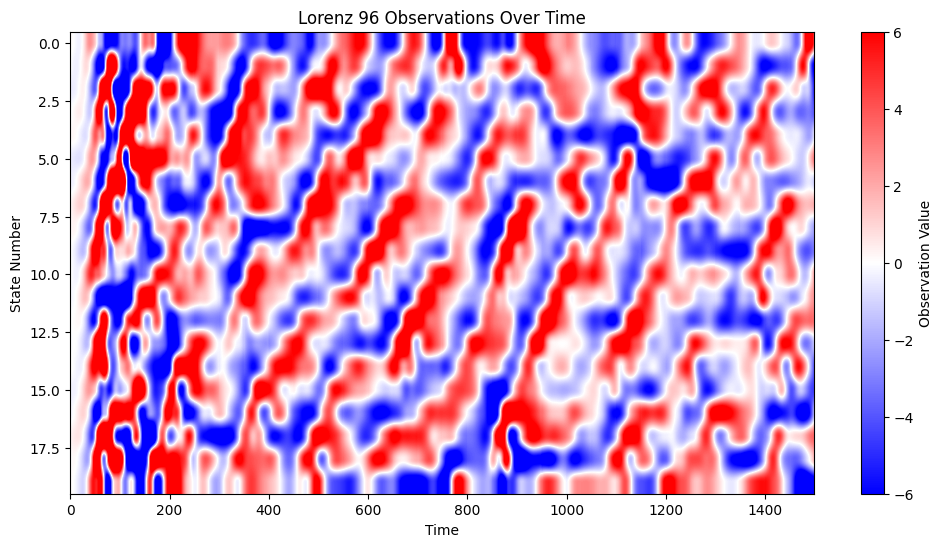

In [ ]:
average_forecast = np.mean(free_run_data['forecasts'], axis = 2)
forecast_errors = {}
t = 1
for forecast in average_forecast[1:]:
    forecast_errors[t] = forecast - states[t]
    t += 1

visualize_lorenz96_observations(forecast_errors)


In [ ]:
def plot_ensemble_mean_and_variance(data_storage, true_states, observations, state_index, title_suffix=''):
    """
    Plot the ensemble mean and variance for a specific state index, along with observations.

    :param data_storage: Dictionary containing states, predictions, forecasts, and observations.
    :param state_index: Index of the state to plot (e.g., 0, 1, 2).
    :param title_suffix: Suffix for the plot title.
    """
    time_steps = np.arange(len(data_storage['states']))

    # Calculate the mean and standard deviation of the forecasts
    forecast_mean = np.mean(data_storage['forecasts'][:, state_index, :], axis=1)
    forecast_std = np.std(data_storage['forecasts'][:, state_index, :], axis=1)

    plt.figure(figsize=(12, 8))

    # Plot the mean of the forecasts
    plt.plot(time_steps, forecast_mean, label='Forecast Mean', color='orange')
    states = [arr[1][state_index] for arr in true_states.items()]

    plt.plot(time_steps, states, label='True States')

    # Plot a 95% confidence interval for the forecasts
    plt.fill_between(time_steps,
                     forecast_mean - 1.96 * forecast_std,
                     forecast_mean + 1.96 * forecast_std,
                     color='orange', alpha=0.3, label='95% Confidence Interval')

    # Plot the observations
    observed_time_steps = observations.keys()
    observed_values = [observations[t][state_index] for t in observed_time_steps]
    plt.scatter(observed_time_steps, observed_values, label='Observation', color='red')

    plt.title(f'State {state_index+1} Ensemble Mean and Variance {title_suffix}')
    plt.xlabel('Time Step')
    plt.ylabel(f'State {state_index+1} Value')
    plt.legend()
    plt.show()


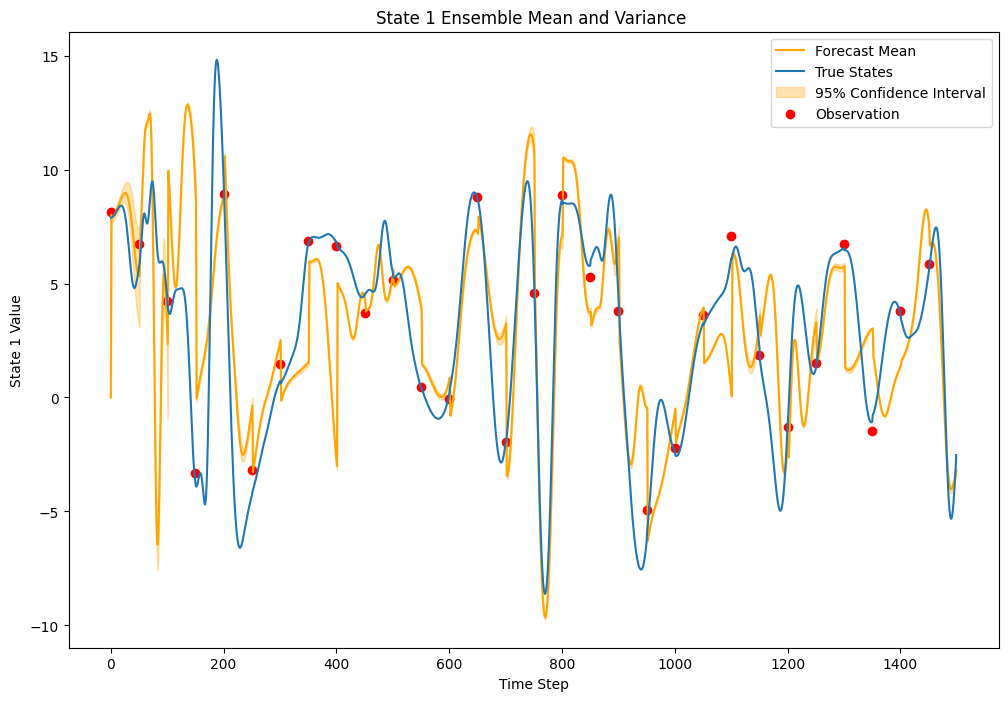

In [ ]:
plot_ensemble_mean_and_variance(data_storage, states, observations, 0, title_suffix='')

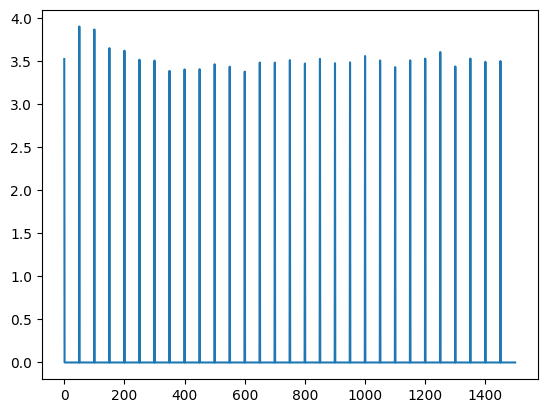

In [ ]:
plt.plot(data_storage['K_norms'])

<ipython-input-85-c90a9b2fa348>:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  print(np.mean(np.sqrt(np.mean((np.mean(data_storage['forecasts'], axis=2) - np.vstack(states.values()))**2, axis=1)[knorms != 0])))


1.5844380907466256
2.3289072810909706
2.6044044873100813
4.407175103916688


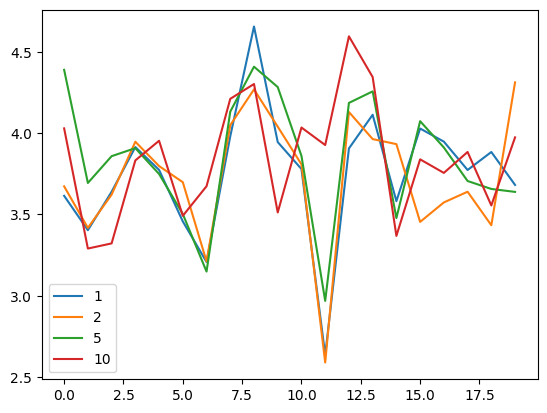

In [ ]:
for radius in [1,2,5,10]:
    # Kalman Filter parameters for Lorenz 96
    H = np.eye(N)  # Assuming full observation for simplicity
    #Q = 0.02 * np.eye(N)  # Model noise covariance
    #R = 0.2 * np.eye(N) # Observation noise covariance
    n_ensemble = 20
    ensemble_init = np.random.multivariate_normal(initial_state, Q, n_ensemble).T
    local_mat = generate_gc_localization_matrix(N, radius)
    # Run the Kalman Filter for Lorenz 96
    data_storage = stochastic_ensemble_kalman_filter(lorenz96, N, n_ensemble, ensemble_init, n_timesteps, dt, H, observations, R, Q, local_mat)
    #plot_ensemble_mean_and_variance(data_storage, states, observations, 0, title_suffix='for localization radius ' + str(radius))
    knorms = data_storage['K_norms']
    filtered_data = knorms[knorms != 0]
    #plt.plot(filtered_data, label = radius)
    #plt.plot(np.sqrt(np.mean((np.mean(data_storage['forecasts'], axis=2) - np.vstack(states.values()))**2, axis=1)[knorms != 0]), label=radius)
    plt.plot(np.std(data_storage['forecasts'], axis=(1,2))[knorms != 0][10:], label=radius)
    print(np.mean(np.sqrt(np.mean((np.mean(data_storage['forecasts'], axis=2) - np.vstack(states.values()))**2, axis=1)[knorms != 0])))
plt.legend()

In [ ]:
np.std(data_storage['forecasts'], axis=(1,2)).shape

(1500,)